In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path

import torch

from utils.data import get_dataset_iterator
from utils.timediffusion import TimeDiffusion, ma, is_high_freq

data_path = Path("data")
fuel_prices_dataset_path = data_path / "fuel_prices"

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
epochs = 20
steps_per_epoch = 32
steps_to_gen = set(range(1, steps_per_epoch + 1))
max_gen_step = max(steps_to_gen) + 1
batch_size = 32

In [3]:
def get_exchange_rate(filepath):
    with open(filepath, "r") as f:
        lines = f.readlines()
    lines = [list(map(float, line.split(','))) for line in lines]
    return pd.DataFrame(lines, columns=[f"ts{i}" for i in range(8)])

In [4]:
df = get_exchange_rate(data_path / "exchange_rate.txt")
df

,ts0,ts1,ts2,ts3,ts4,ts5,ts6,ts7
0,0.785500,1.611000,0.861698,0.634196,0.211242,0.006838,0.593000,0.525486
1,0.781800,1.610000,0.861104,0.633513,0.211242,0.006863,0.594000,0.523972
2,0.786700,1.629300,0.861030,0.648508,0.211242,0.006975,0.597300,0.526316
3,0.786000,1.637000,0.862069,0.650618,0.211242,0.006953,0.597000,0.523834
4,0.784900,1.653000,0.861995,0.656254,0.211242,0.006940,0.598500,0.527426
...,...,...,...,...,...,...,...,...
7583,0.718494,1.222195,0.737485,0.969974,0.143697,0.008500,0.690846,0.688565
7584,0.721839,1.223459,0.741155,0.977297,0.143763,0.008595,0.695701,0.690288
7585,0.723197,1.234111,0.745184,0.984446,0.143997,0.008562,0.695943,0.691419
7586,0.720825,1.233905,0.744131,0.980344,0.143993,0.008555,0.692689,0.690942


100%|██████████| 20/20 [01:08<00:00,  3.42s/it]


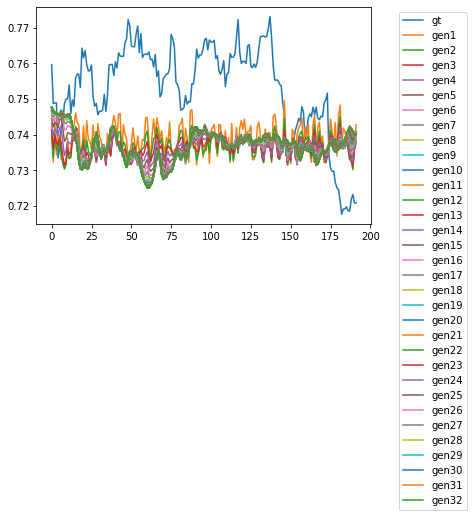

In [20]:
time_series = df["ts0"]
horizon = 192
lags = horizon
time_series = time_series.values.flatten()[- horizon - lags:]

train = time_series[: - horizon]
tmean = train.mean()
tstd = train.std()
train = (train - tmean) / tstd
train_tensor = torch.from_numpy(train).float().to(device)

torch.random.manual_seed(0)
model = TimeDiffusion().to(device)
optim = torch.optim.AdamW(model.parameters(), lr=4e-4)
losses = []

for epoch in tqdm(range(1, epochs + 1)):
    model.train()
    X = train_tensor.repeat(batch_size, 1).unsqueeze(1)
    noise = torch.row_stack([torch.rand(1, *X.shape[1:]) for _ in range(X.shape[0])]).to(device)
    noise_level = torch.rand(X.shape).to(device)
    noise *= noise_level

    for step in range(steps_per_epoch):
        optim.zero_grad()
        y_hat = model(X + noise)
        loss = (y_hat - noise).abs().mean()
        loss.backward()
        optim.step()
        with torch.no_grad():
            noise -= y_hat
        losses.append(loss.item())

model.eval()
result = []
with torch.no_grad():
    generated = torch.rand(1, 1, len(time_series)).to(device)
    for step in range(1, steps_per_epoch + 1):
        pred_noise = model(generated)
        generated -= pred_noise
        if step in steps_to_gen:
            result.append(generated.detach().cpu().numpy().squeeze() * tstd + tmean)
result = np.row_stack(result)

plt.plot(time_series[len(train):])
for i, _ in enumerate(steps_to_gen):
    plt.plot(result[i][len(train):])
plt.legend(["gt"] + [f"gen{i}" for i in steps_to_gen], bbox_to_anchor=(1.3, 1.0))
plt.show()

lags = coef * horizon, horizon = 192

coef, best step and its score; last step score

5; 1 step: 0.05; lst step: 0.012

4; 2 step: 0.01; lst step: 0.021

3; 12 step: 0.0108; lst step: 0.011

2; 6 step: 0.012; lst step: 0.013

1; 1 step: 0.01736; lst step: 0.0193

In [21]:
[np.abs(result[i][- horizon:] - time_series[- horizon:]).mean() for i in range(len(result))]

[0.017362915189325808,
 0.018714658162931597,
 0.019082402367830275,
 0.01916175689357519,
 0.019187542634526888,
 0.01920924978739023,
 0.019235925582289693,
 0.01924971761069695,
 0.01926042937250932,
 0.019266565546512602,
 0.019270974117139975,
 0.01927437406541904,
 0.019278566569209097,
 0.019282829232633112,
 0.019286826779564222,
 0.01929062564434608,
 0.019294014106313387,
 0.01929684998355309,
 0.019299289427816866,
 0.019301254828890165,
 0.019302793684224287,
 0.019303977084775766,
 0.01930481682729721,
 0.019305365376293657,
 0.019305677058915297,
 0.019305807133634886,
 0.019305800303936003,
 0.01930568481993675,
 0.019305454472819963,
 0.01930514185887575,
 0.01930477553866307,
 0.019304397421697775]

100%|██████████| 20/20 [02:12<00:00,  6.63s/it]


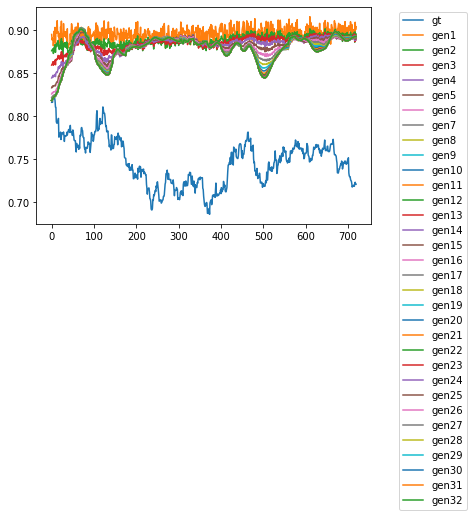

In [22]:
time_series = df["ts0"]
horizon = 720
lags = horizon
time_series = time_series.values.flatten()[- horizon - lags:]

train = time_series[: - horizon]
tmean = train.mean()
tstd = train.std()
train = (train - tmean) / tstd
train_tensor = torch.from_numpy(train).float().to(device)

torch.random.manual_seed(0)
model = TimeDiffusion().to(device)
optim = torch.optim.AdamW(model.parameters(), lr=4e-4)
losses = []

for epoch in tqdm(range(1, epochs + 1)):
    model.train()
    X = train_tensor.repeat(batch_size, 1).unsqueeze(1)
    noise = torch.row_stack([torch.rand(1, *X.shape[1:]) for _ in range(X.shape[0])]).to(device)
    noise_level = torch.rand(X.shape).to(device)
    noise *= noise_level

    for step in range(steps_per_epoch):
        optim.zero_grad()
        y_hat = model(X + noise)
        loss = (y_hat - noise).abs().mean()
        loss.backward()
        optim.step()
        with torch.no_grad():
            noise -= y_hat
        losses.append(loss.item())

model.eval()
result = []
with torch.no_grad():
    generated = torch.rand(1, 1, len(time_series)).to(device)
    for step in range(1, steps_per_epoch + 1):
        pred_noise = model(generated)
        generated -= pred_noise
        if step in steps_to_gen:
            result.append(generated.detach().cpu().numpy().squeeze() * tstd + tmean)
result = np.row_stack(result)

plt.plot(time_series[len(train):])
for i, _ in enumerate(steps_to_gen):
    plt.plot(result[i][len(train):])
plt.legend(["gt"] + [f"gen{i}" for i in steps_to_gen], bbox_to_anchor=(1.3, 1.0))
plt.show()

lags = horizon = 720

best step = lst step: 0.131

In [23]:
[np.abs(result[i][- horizon:] - time_series[- horizon:]).mean() for i in range(len(result))]

[0.1491033386145804,
 0.14114055957609814,
 0.13814835243305632,
 0.1363756472158538,
 0.13502737177293567,
 0.13389470330093703,
 0.13299658804682626,
 0.13235468949155277,
 0.13191033284420967,
 0.1316010671081331,
 0.13138962757807837,
 0.13124917155062357,
 0.13115782842591603,
 0.13109925411365297,
 0.13106214169550473,
 0.1310388394179609,
 0.1310242662478818,
 0.1310151382932398,
 0.1310094361155563,
 0.13100587920837933,
 0.13100367226362228,
 0.1310023117876053,
 0.13100148162735833,
 0.1310009851703379,
 0.13100069625337918,
 0.13100053581754367,
 0.1310004550201363,
 0.13100041967127057,
 0.131000411144495,
 0.13100041602876453,
 0.13100042645957735,
 0.13100043763544825]

Exps with different epochs

100%|██████████| 4/4 [00:07<00:00,  1.76s/it]


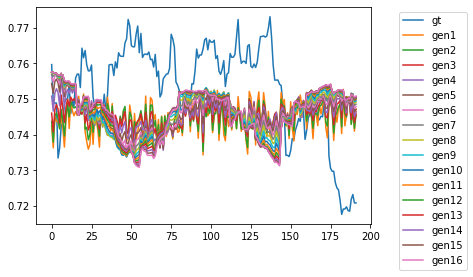

best step is 3: 0.0136; lst step:  0.0155


In [45]:
epochs = 4
steps_per_epoch = 16
steps_to_gen = set(range(1, steps_per_epoch + 1))
max_gen_step = max(steps_to_gen) + 1
batch_size = 32

time_series = df["ts0"]
horizon = 192
lags = horizon
time_series = time_series.values.flatten()[- horizon - lags:]

train = time_series[: - horizon]
tmean = train.mean()
tstd = train.std()
train = (train - tmean) / tstd
train_tensor = torch.from_numpy(train).float().to(device)

torch.random.manual_seed(0)
model = TimeDiffusion().to(device)
optim = torch.optim.AdamW(model.parameters(), lr=4e-4)
losses = []

for epoch in tqdm(range(1, epochs + 1)):
    model.train()
    X = train_tensor.repeat(batch_size, 1).unsqueeze(1)
    noise = torch.row_stack([torch.rand(1, *X.shape[1:]) for _ in range(X.shape[0])]).to(device)
    noise_level = torch.rand(X.shape).to(device)
    noise *= noise_level

    for step in range(steps_per_epoch):
        optim.zero_grad()
        y_hat = model(X + noise)
        loss = (y_hat - noise).abs().mean()
        loss.backward()
        optim.step()
        with torch.no_grad():
            noise -= y_hat
        losses.append(loss.item())

model.eval()
result = []
with torch.no_grad():
    generated = torch.rand(1, 1, len(time_series)).to(device)
    for step in range(1, steps_per_epoch + 1):
        pred_noise = model(generated)
        generated -= pred_noise
        if step in steps_to_gen:
            result.append(generated.detach().cpu().numpy().squeeze() * tstd + tmean)
result = np.row_stack(result)

plt.plot(time_series[len(train):])
for i, _ in enumerate(steps_to_gen):
    plt.plot(result[i][len(train):])
plt.legend(["gt"] + [f"gen{i}" for i in steps_to_gen], bbox_to_anchor=(1.3, 1.0))
plt.show()

maes = [np.abs(result[i][- horizon:] - time_series[- horizon:]).mean() for i in range(len(result))]
print(f"best step is {np.argmin(maes) + 1}: {min(maes):0.4f}; lst step: {maes[- 1]: 0.4f}")

horizon = lags = 192; steps = 32

epochs 50: best step is 1: 0.0169; lst step:  0.0185

epochs 20: best step is 1: 0.0177; lst step:  0.0198               ---------------- ~ 2 min = 640 steps

epochs 10: best step is 1: 0.0201; lst step:  0.0219

epochs 5: best step is 20: 0.0169; lst step:  0.0169

epochs 4: best step is 5: 0.0151; lst step:  0.0154

epochs 3: best step is 5: 0.0211; lst step:  0.0218

epochs 2: best step is 1: 0.0159; lst step:  0.0168

epochs 1: best step is 13: 0.0206; lst step:  0.0213


steps = 20

epochs 50: best step is 1: 0.0178; lst step:  0.0192

epochs 20: best step is 1: 0.0185; lst step:  0.0196

epochs 10: best step is 1: 0.0210; lst step:  0.0215

epochs 5: best step is 6: 0.0233; lst step:  0.0234

epochs 4: best step is 1: 0.0156; lst step:  0.0160

epochs 3: best step is 20: 0.0150; lst step:  0.0150

epochs 2: best step is 2: 0.0195; lst step:  0.0200

epochs 1: best step is 8: 0.0106; lst step:  0.0109

steps = 16

epochs 50: best step is 1: 0.0165; lst step:  0.0176

epochs 20: best step is 1: 0.0197; lst step:  0.0216

epochs 10: best step is 10: 0.0178; lst step:  0.0178

epochs 5: best step is 1: 0.0208; lst step:  0.0244

epochs 4: best step is 3: 0.0133; lst step:  0.0156   ---   best result

epochs 3: best step is 1: 0.0168; lst step:  0.0177

epochs 2: best step is 2: 0.0198; lst step:  0.0203

epochs 1: best step is 16: 0.0106; lst step:  0.0106

steps = 8

epochs 50: best step is 1: 0.0196; lst step:  0.0231

epochs 20: best step is 1: 0.0217; lst step:  0.0244

epochs 4: best step is 1: 0.0198; lst step:  0.0212

100%|██████████| 50/50 [05:59<00:00,  7.19s/it]


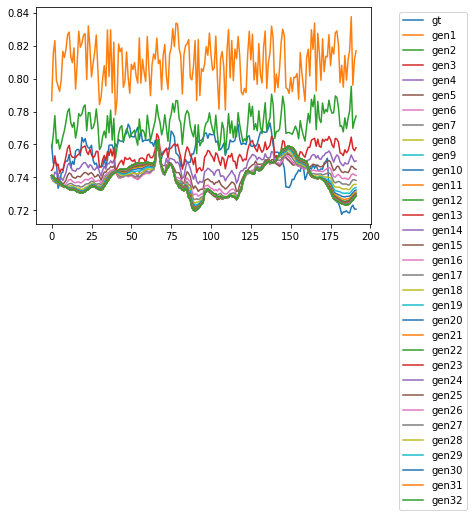

best step is 3: 0.0115; lst step:  0.0172


In [56]:
epochs = 50
steps_per_epoch = 32
steps_to_gen = set(range(1, steps_per_epoch + 1))
max_gen_step = max(steps_to_gen) + 1
batch_size = 32

time_series = df["ts0"]
horizon = 192
lags = horizon * 5
time_series = time_series.values.flatten()[- horizon - lags:]

train = time_series[: - horizon]
tmean = train.mean()
tstd = train.std()
train = (train - tmean) / tstd
train_tensor = torch.from_numpy(train).float().to(device)

torch.random.manual_seed(0)
model = TimeDiffusion().to(device)
optim = torch.optim.AdamW(model.parameters(), lr=4e-4)
losses = []

for epoch in tqdm(range(1, epochs + 1)):
    model.train()
    X = train_tensor.repeat(batch_size, 1).unsqueeze(1)
    noise = torch.row_stack([torch.rand(1, *X.shape[1:]) for _ in range(X.shape[0])]).to(device)
    noise_level = torch.rand(X.shape).to(device)
    noise *= noise_level

    for step in range(steps_per_epoch):
        optim.zero_grad()
        y_hat = model(X + noise)
        loss = (y_hat - noise).abs().mean()
        loss.backward()
        optim.step()
        with torch.no_grad():
            noise -= y_hat
        losses.append(loss.item())

model.eval()
result = []
with torch.no_grad():
    generated = torch.rand(1, 1, len(time_series)).to(device)
    for step in range(1, steps_per_epoch + 1):
        pred_noise = model(generated)
        generated -= pred_noise
        if step in steps_to_gen:
            result.append(generated.detach().cpu().numpy().squeeze() * tstd + tmean)
result = np.row_stack(result)

plt.plot(time_series[len(train):])
for i, _ in enumerate(steps_to_gen):
    plt.plot(result[i][len(train):])
plt.legend(["gt"] + [f"gen{i}" for i in steps_to_gen], bbox_to_anchor=(1.3, 1.0))
plt.show()

maes = [np.abs(result[i][- horizon:] - time_series[- horizon:]).mean() for i in range(len(result))]
print(f"best step is {np.argmin(maes) + 1}: {min(maes):0.4f}; lst step: {maes[- 1]: 0.4f}")

horizon = lags * 5; lags = 192

steps = 32

epochs 50: best step is 3: 0.0115; lst step:  0.0172

epochs 20: best step is 4: 0.0112; lst step:  0.0131

epochs 10: best step is 2: 0.0111; lst step:  0.0151

epochs 4: best step is 2: 0.0108; lst step:  0.0236

steps = 16

epochs 50: best step is 4: 0.0117; lst step:  0.0149

epochs 20: best step is 9: 0.0086; lst step:  0.0102 | best step is 2: 0.0122; lst step:  0.0240 | best step is 3: 0.0109; lst step:  0.0123

epochs 5: best step is 4: 0.0094; lst step:  0.0095  --- almost constant

epochs 4: best step is 2: 0.0102; lst step:  0.0213

validation try

100%|██████████| 4/4 [00:12<00:00,  3.17s/it]


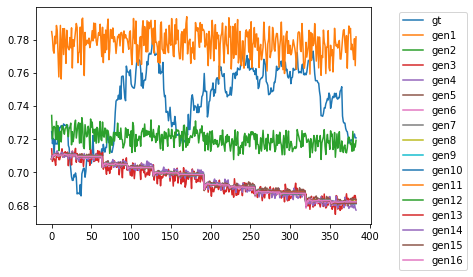

best step is 1: 0.0240;  lst step:  0.0655 best valid step 2:  0.0348


In [65]:
epochs = 4
steps_per_epoch = 16
steps_to_gen = set(range(1, steps_per_epoch + 1))
max_gen_step = max(steps_to_gen) + 1
batch_size = 32

time_series = df["ts0"]
horizon = 192
lags = horizon * 3
time_series = time_series.values.flatten()[- 2 * horizon - lags:]

train = time_series[: - 2 * horizon]
tmean = train.mean()
tstd = train.std()
train = (train - tmean) / tstd
train_tensor = torch.from_numpy(train).float().to(device)

torch.random.manual_seed(0)
model = TimeDiffusion().to(device)
optim = torch.optim.AdamW(model.parameters(), lr=4e-4)
losses = []

for epoch in tqdm(range(1, epochs + 1)):
    model.train()
    X = train_tensor.repeat(batch_size, 1).unsqueeze(1)
    noise = torch.row_stack([torch.rand(1, *X.shape[1:]) for _ in range(X.shape[0])]).to(device)
    noise_level = torch.rand(X.shape).to(device)
    noise *= noise_level

    for step in range(steps_per_epoch):
        optim.zero_grad()
        y_hat = model(X + noise)
        loss = (y_hat - noise).abs().mean()
        loss.backward()
        optim.step()
        with torch.no_grad():
            noise -= y_hat
        losses.append(loss.item())

model.eval()
result = []
with torch.no_grad():
    generated = torch.rand(1, 1, len(time_series)).to(device)
    for step in range(1, steps_per_epoch + 1):
        pred_noise = model(generated)
        generated -= pred_noise
        if step in steps_to_gen:
            result.append(generated.detach().cpu().numpy().squeeze() * tstd + tmean)
result = np.row_stack(result)

plt.plot(time_series[len(train):])
for i, _ in enumerate(steps_to_gen):
    plt.plot(result[i][len(train):])
plt.legend(["gt"] + [f"gen{i}" for i in steps_to_gen], bbox_to_anchor=(1.3, 1.0))
plt.show()

maes_valid = [np.abs(result[i][- 2 * horizon: - horizon] - time_series[- 2 * horizon: - horizon]).mean() for i in range(len(result))]
bvstep = np.argmin(maes_valid) + 1

maes = [np.abs(result[i][- horizon:] - time_series[- horizon:]).mean() for i in range(len(result))]
print(f"best step is {np.argmin(maes) + 1}: {min(maes):0.4f};  lst step: {maes[- 1]: 0.4f} best valid step {bvstep}: {maes[bvstep - 1]: 0.4f}")

lags = 4 * horizon + horizon valid + horizon test

steps = 32

epochs 50: best step is 2: 0.0118;  lst step:  0.0236 best valid step 9: 0.0236

epochs 20: best step is 2: 0.0102;  lst step:  0.0234 best valid step 28:  0.0234

epochs 10: best step is 2: 0.0100;  lst step:  0.0292 best valid step 3:  0.0189

epochs 4: best step is 2: 0.0245;  lst step:  0.0546 best valid step 2:  0.0245

steps = 16

epochs 50: best step is 2: 0.0115;  lst step:  0.0243 best valid step 4:  0.0214

epochs 20: best step is 2: 0.0142;  lst step:  0.0316 best valid step 3:  0.0254

epochs 10: best step is 2: 0.0178;  lst step:  0.0306 best valid step 5:  0.0301

epochs 4: best step is 1: 0.0240;  lst step:  0.0655 best valid step 2:  0.0348